In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
sns.set(color_codes=True)

- Cada conjunto de datos consiste en archivos individuales que son instantáneas de señales de vibración de 1 segundo grabadas a intervalos específicos. 
- Cada archivo consta de 20.480 puntos con la tasa de muestreo fijada en 20 kHz. El nombre del archivo indica cuándo se recogieron los datos. 
- Cada registro (fila) en el archivo de datos es un punto de datos. Los intervalos más grandes de marcas de tiempo (mostrados en los nombres de los archivos) indican la reanudación del experimento en el siguiente día laborable.

---

Se supone que la degradación del engranaje se produce gradualmente con el tiempo, por lo que utilizamos un punto de datos cada 10 minutos en el siguiente análisis. 
Cada punto de datos de 10 minutos se agrega utilizando el valor absoluto medio de los registros de vibración de los registros de vibración en los 20.480 puntos de datos de cada archivo. A continuación, se fusiona todo en un único dataframe.

En esta práctica se utilizan los datos de la prueba de fallo del 2º engranaje 

In [2]:
# Cargar los datos

data_dir = './2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    print(filename)
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs])

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

2004.02.14.01.42.39
2004.02.15.18.12.39
2004.02.12.12.22.39
2004.02.18.23.52.39
2004.02.14.16.32.39
2004.02.14.04.12.39
2004.02.14.08.12.39
2004.02.12.19.22.39
2004.02.15.18.02.39
2004.02.18.18.22.39
2004.02.13.23.52.39
2004.02.16.21.02.39
2004.02.18.17.12.39
2004.02.17.23.12.39
2004.02.17.18.12.39
2004.02.16.01.22.39
2004.02.12.22.02.39
2004.02.13.02.22.39
2004.02.13.17.12.39
2004.02.14.12.42.39
2004.02.15.08.12.39
2004.02.13.06.22.39
2004.02.14.18.22.39
2004.02.17.03.32.39
2004.02.14.16.12.39
2004.02.17.22.32.39
2004.02.17.16.52.39
2004.02.15.19.12.39
2004.02.14.15.12.39
2004.02.18.19.02.39
2004.02.15.09.12.39
2004.02.13.09.22.39
2004.02.19.01.32.39
2004.02.12.16.52.39
2004.02.17.04.02.39
2004.02.16.17.32.39
2004.02.16.21.32.39
2004.02.18.04.12.39
2004.02.16.07.32.39
2004.02.14.02.22.39
2004.02.16.11.42.39
2004.02.17.01.32.39
2004.02.16.10.22.39
2004.02.18.23.32.39
2004.02.18.19.12.39
2004.02.17.02.22.39
2004.02.19.04.12.39
2004.02.14.00.22.39
2004.02.14.21.42.39
2004.02.16.07.12.39


In [3]:
# Después de cargar los datos de vibración, transformamos el índice a formato de fecha y hora
# y luego ordenamos los datos por índice en orden cronológico antes de guardar el conjunto de datos combinados como archivo .csv

merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


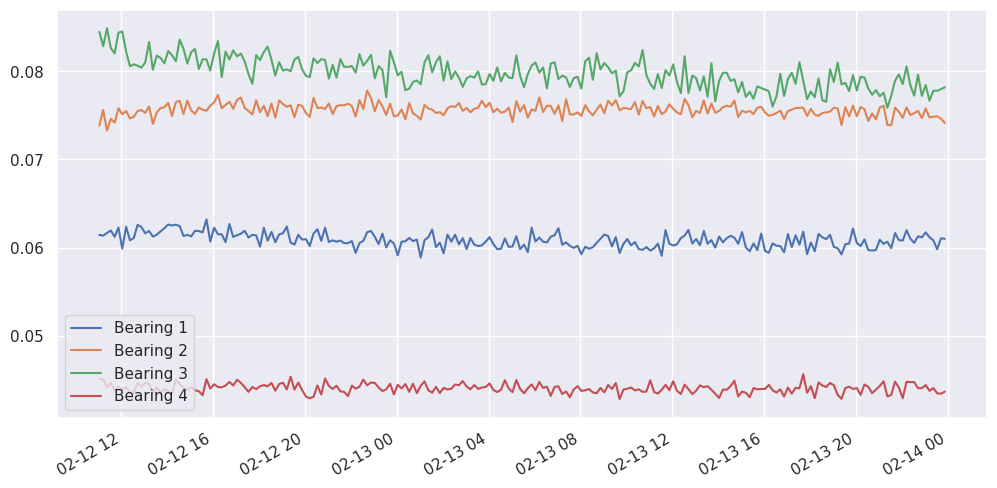

In [4]:
# Antes de configurar los modelos, tenemos que definir los datos de entrenamiento/prueba. 
# Para ello, realizamos una simple división en la que entrenamos la primera parte del conjunto de datos 
# (que debería representar las condiciones normales de funcionamiento) 
# y probamos las partes restantes del conjunto de datos que conducen al fallo del rodamiento.

dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize=(12, 6))
scaler = preprocessing.MinMaxScaler()

In [8]:
X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                       columns=dataset_train.columns,
                       index=dataset_train.index)

# Permutación aleatoria de los datos de entrada
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test),
                      columns=dataset_test.columns,
                      index=dataset_test.index)

# Reducimos las lecturas de los sensores a los dos primeras componentes principales.

from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [6]:

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: La inversa de la matriz de covarianza no es definida positiva.")
    else:
        print("Error: La matriz de covarianza no es definida positiva.")


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md


def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # índice del outlier
    return np.array(outliers)


# Umbral para clasificar si un punto es una anomalía
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold


# Comprobar si la matriz es definida positiva
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [9]:
# Modelo PCA
# Definimos train y test con las dos primeras componentes principales
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

# Calculamos matrices de covarianza e inversa
cov_matrix, inv_cov_matrix = cov_matrix(data_train)

In [10]:
# También calculamos el valor medio de las variables de entrada en el conjunto de entrenamiento, ya que se utiliza 
# para calcular la distancia de Mahalanobis a los puntos de datos del conjunto de pruebas.
mean_distr = data_train.mean(axis=0)

In [11]:
# Utilizando la matriz de covarianza y su inversa, podemos calcular la distancia de Mahalanobis para 
# los datos de entrenamiento que definen las "condiciones normales", y encontrar el valor umbral para marcar los puntos de datos como una anomalía. 
# A continuación, se puede calcular la distancia de Mahalanobis para los puntos de datos del conjunto de pruebas y compararla con el umbral de anomalía.
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme=True)

/tmp/ipykernel_73797/3853738524.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.square(dist_train),


(0.0, 15.0)

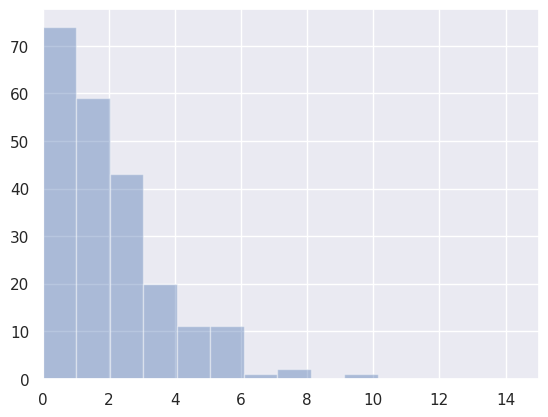

In [12]:
# Valor umbral para marcar una anomalía:
# El cuadrado de la distancia de Mahalanobis al centroide de la distribución debería seguir una distribución χ2 
# si se cumple el supuesto de que las variables de entrada tienen una distribución normal. 
# Este es también el supuesto en el que se basa el cálculo anterior del "valor umbral" para marcar una anomalía. 
# Como este supuesto no se cumple necesariamente en nuestro caso, es beneficioso visualizar la distribución de la 
# distancia de Mahalanobis para establecer un buen valor umbral para marcar las anomalías. 
# Comenzamos visualizando el cuadrado de la distancia de Mahalanobis, que debería seguir idealmente una distribución χ2.

plt.figure()
sns.distplot(np.square(dist_train),
             bins=10,
             kde=False);
plt.xlim([0.0, 15])

/tmp/ipykernel_73797/1761021355.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_train,


Text(0.5, 0, 'Mahalanobis dist')

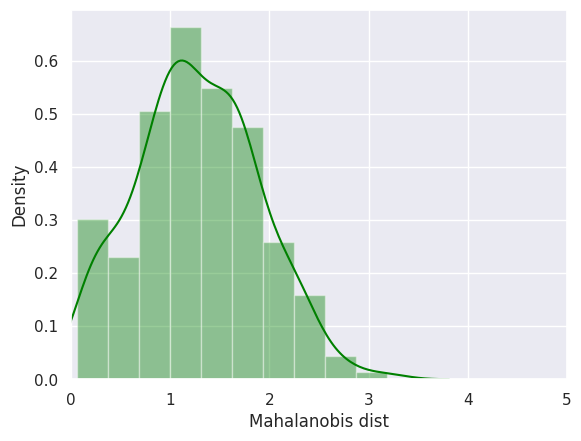

In [13]:
# A continuación se visualiza la propia distancia
plt.figure()
sns.distplot(dist_train,
             bins=10,
             kde=True,
             color='green');
plt.xlim([0.0, 5])
plt.xlabel('Mahalanobis dist')

In [14]:
# A partir de las distribuciones anteriores, un valor de umbral de 3.8 para señalar una anomalía parece 
# razonable (definido como 3 desviaciones estándar del centro de la distribución)
# A continuación, podemos guardar la distancia de Mahalanobis, así como el valor del umbral y la variable "indicador de anomalía" 
# para los datos de entrenamiento y de prueba en un dataframe:

anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold
# Distancia mayor que umbral: marcamos como anomalía
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold
# Distancia mayor que umbral: marcamos como anomalía
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


<AxesSubplot: >

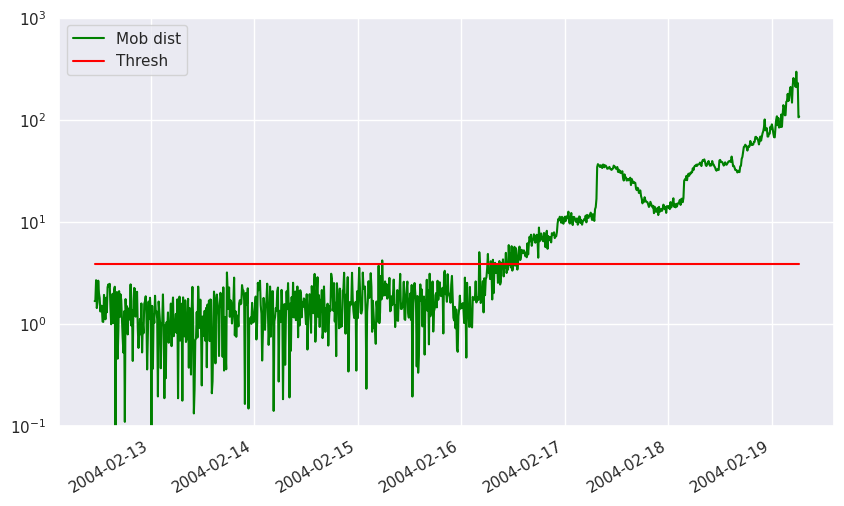

In [16]:
# Juntamos todo en un único csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

# Verificación del modelo PCA en los datos de prueba:
# Ahora podemos trazar la métrica de anomalía calculada (Mob dist), y comprobar cuándo 
# cruza el umbral de anomalía (observe el eje logarítmico y).
anomaly_alldata.plot(logy=True, figsize=(10, 6), ylim=[1e-1, 1e3], color=['green', 'red'])


In [39]:
def get_averia(data, window=10):
    return data.rolling(window).sum().ge(window).idxmax()

                     distanciaKNN  Thresh  Anomaly
2004-02-13 23:52:39      0.222004     0.5    False
2004-02-14 00:02:39      0.190006     0.5    False
2004-02-14 00:12:39      0.166716     0.5    False
2004-02-14 00:22:39      0.182678     0.5    False
2004-02-14 00:32:39      0.199767     0.5    False
Día de la avería:  2004-02-16 04:42:39


<AxesSubplot: >

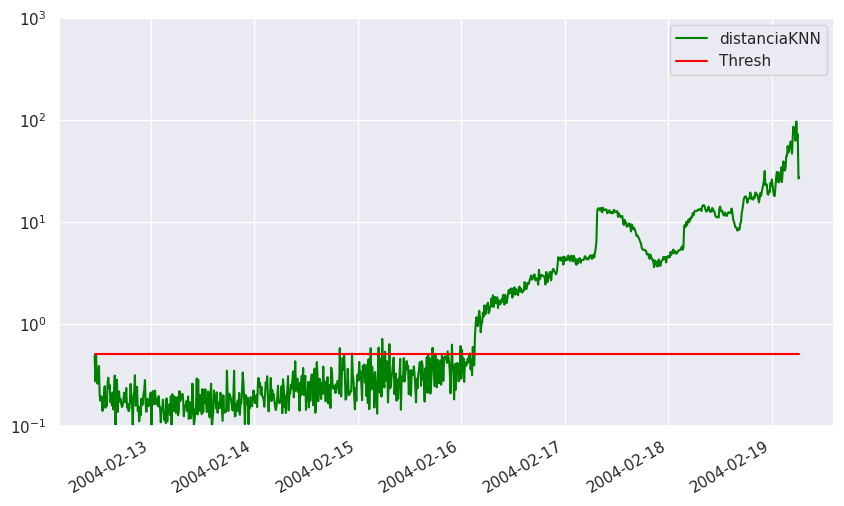

In [40]:
# Apartado 1:
# Detección de anomalías con KNN: Calcula el número de vecinos y el umbral necesario 
# para detectar la anomalía y compara los resultados 

from sklearn.neighbors import NearestNeighbors

vecinos = 6
threshold = 0.5

nbrs = NearestNeighbors(n_neighbors=vecinos, algorithm='ball_tree').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)
dist_test, indices_test = nbrs.kneighbors(X_test)

anomaly_train = pd.DataFrame()
anomaly_train.index = X_train.index
anomaly_train['distanciaKNN'] = distances[:, vecinos - 1]
anomaly_train['Thresh'] = threshold
# Distancia mayor que umbral: marcamos como anomalía
anomaly_train['Anomaly'] = anomaly_train['distanciaKNN'] > anomaly_train['Thresh']

anomaly = pd.DataFrame()
anomaly.index = X_test.index
anomaly['distanciaKNN'] = dist_test[:, vecinos - 1]
anomaly['Thresh'] = threshold
# Distancia mayor que umbral: marcamos como anomalía
anomaly['Anomaly'] = anomaly['distanciaKNN'] > anomaly['Thresh']

print(anomaly.head())

# Juntamos todo en un único csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance_KNN.csv')

print("Día de la avería: ", get_averia(anomaly['Anomaly']))


# Dibujo del resultado
anomaly_alldata.plot(logy=True, figsize=(10, 6), ylim=[1e-1, 1e3], color=['green', 'red'])

                     Anomaly  LOF
2004-02-13 23:52:39      0.0  NaN
2004-02-14 00:02:39      0.0  NaN
2004-02-14 00:12:39      0.0  NaN
2004-02-14 00:22:39      0.0  NaN
2004-02-14 00:32:39      0.0  NaN
Día de la avería:  2004-02-16 02:22:39


<AxesSubplot: >

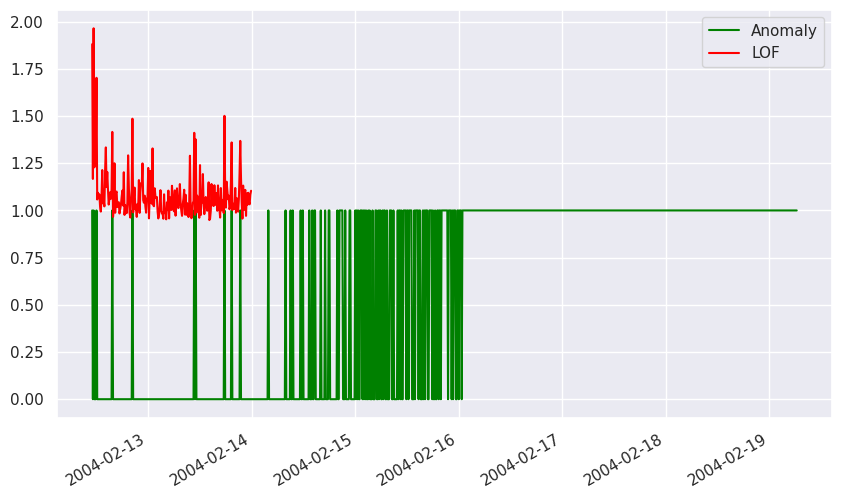

In [41]:
# Apartado 2:
# Detección de anomalías con LOF: Calcula la fracción de outliers necesaria
# para detectar la anomalía y compara los resultados 

from sklearn.neighbors import LocalOutlierFactor

outlier_fraction = 0.05

LOF = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                         leaf_size=30, metric='minkowski', p=2,
                         metric_params=None, contamination=outlier_fraction, novelty=True)

LOF.fit(X_train.to_numpy())

y_pred_train = LOF.predict(X_train.to_numpy())
y_pred_test = LOF.predict(X_test.to_numpy())

anomaly_train = pd.DataFrame()
anomaly_train.index = X_train.index
anomaly_train['Anomaly'] = 1.0 * (y_pred_train < 0)
anomaly_train['LOF'] = -LOF.negative_outlier_factor_

anomaly = pd.DataFrame()
anomaly.index = X_test.index
anomaly['Anomaly'] = 1.0 * (y_pred_test < 0)
anomaly['LOF'] = np.nan

print(anomaly.head())

print("Día de la avería: ", get_averia(anomaly['Anomaly']))

# Juntamos todo en un único csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance_LOF.csv')

# Dibujo del resultado
anomaly_alldata.plot(logy=False, figsize=(10, 6), color=['green', 'red'])

                     Anomaly        SVM
2004-02-13 23:52:39      0.0  10.518445
2004-02-14 00:02:39      0.0  10.524082
2004-02-14 00:12:39      0.0  10.476549
2004-02-14 00:22:39      0.0  10.478073
2004-02-14 00:32:39      0.0  10.517148
Día de la avería:  2004-02-16 04:32:39


<AxesSubplot: >

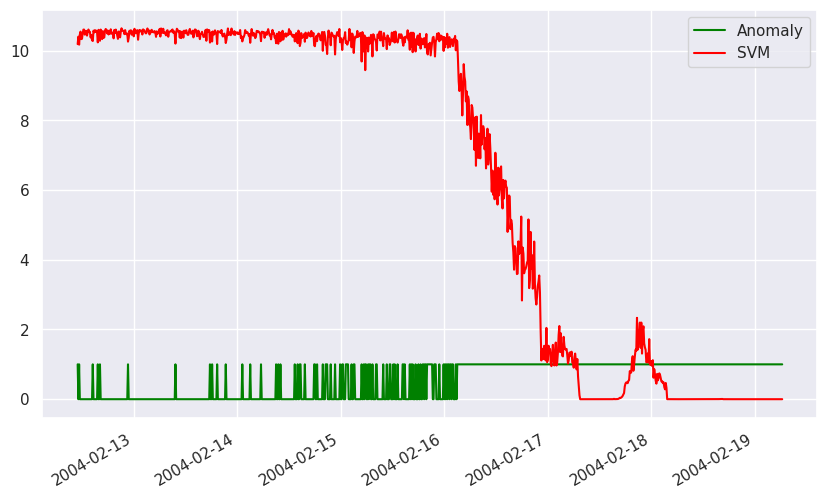

In [42]:
# Apartado 3:
# Detección de anomalías con One-Class SVM: Calcula los parámetros del clasificador necesarios
# para detectar la anomalía con la mayor antelación posible y compara los resultados 

from sklearn.svm import OneClassSVM

SVM = OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)

SVM.fit(X_train)

y_pred_train = SVM.predict(X_train)
y_pred_test = SVM.predict(X_test)

anomaly_train = pd.DataFrame()
anomaly_train.index = X_train.index
anomaly_train['Anomaly'] = 1.0 * (y_pred_train < 0)
anomaly_train['SVM'] = SVM.score_samples(X_train)

anomaly = pd.DataFrame()
anomaly.index = X_test.index
anomaly['Anomaly'] = 1.0 * (y_pred_test < 0)
anomaly['SVM'] = SVM.score_samples(X_test)

print(anomaly.head())

print("Día de la avería: ", get_averia(anomaly['Anomaly']))

# Juntamos todo en un único csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance_SVM.csv')

# Dibujo del resultado
anomaly_alldata.plot(logy=False, figsize=(10, 6), color=['green', 'red'])

                     Anomaly      ISOF
2004-02-13 23:52:39      0.0 -0.497663
2004-02-14 00:02:39      0.0 -0.466589
2004-02-14 00:12:39      0.0 -0.451204
2004-02-14 00:22:39      0.0 -0.465450
2004-02-14 00:32:39      0.0 -0.449304
Día de la avería:  2004-02-15 11:42:39


<AxesSubplot: >

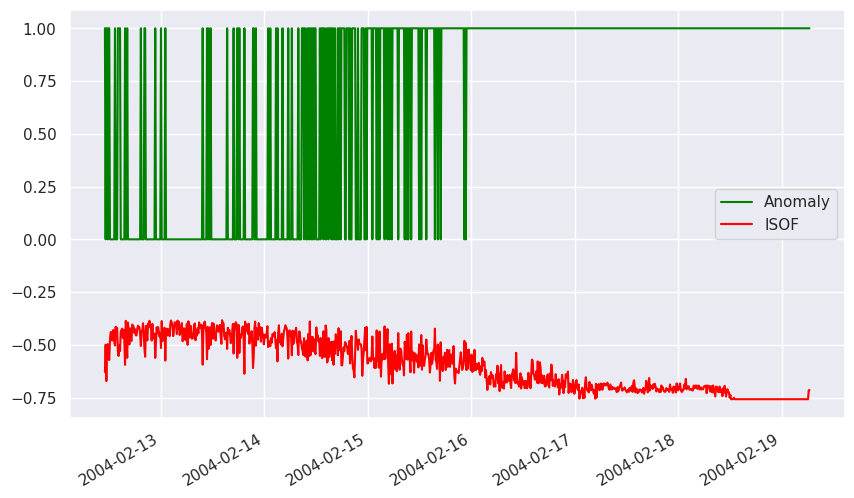

In [43]:
# Apartado 4: (OPCIONAL)
# Haz el mismo análisis con Isolation Forest y compara todos los resultados
from sklearn.ensemble import IsolationForest

ISOF = IsolationForest()

ISOF.fit(X_train)

y_pred_train = ISOF.predict(X_train)
y_pred_test = ISOF.predict(X_test)

anomaly_train = pd.DataFrame()
anomaly_train.index = X_train.index
anomaly_train['Anomaly'] = 1.0 * (y_pred_train < 0)
anomaly_train['ISOF'] = ISOF.score_samples(X_train)

anomaly = pd.DataFrame()
anomaly.index = X_test.index
anomaly['Anomaly'] = 1.0 * (y_pred_test < 0)
anomaly['ISOF'] = ISOF.score_samples(X_test)

print(anomaly.head())

print("Día de la avería: ", get_averia(anomaly['Anomaly']))

# Juntamos todo en un único csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance_ISOF.csv')

# Dibujo del resultado
anomaly_alldata.plot(logy=False, figsize=(10, 6), color=['green', 'red'])